In [53]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Permutation Feature Importance

import eli5
from eli5.sklearn import PermutationImportance

# improve how pandas numbers are displayed
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

In [123]:
def score_prediction(y_test, y_pred):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')
    
    
def corr_plot(mat, title='My Title', color='cividis'):
    plt.subplots(figsize=(14, 11))
    plt.title(title,fontsize=22)

    sns.heatmap(mat,linewidths=0.2,vmax=0.7,square=True,cmap=color, 
                linecolor='w',annot=True,annot_kws={'size':9},cbar_kws={'shrink': .5})

def _tpr(y_actual, y_pred):
    tn, fn, fp, tp = _confusion_matrix(y_actual, y_pred)
    return tp / (tp + fn)

def _fpr(y_actual, y_pred):
    tn, fn, fp, tp = _confusion_matrix(y_actual, y_pred)
    return fp / (fp + tn)

def _roc(y_actual, y_pred):
    tpr = _tpr(y_actual, y_pred)
    fpr = _fpr(y_actual, y_pred)
    return tpr, fpr

def tpr_thresh(thresh):
    y_pred = (y_pred_prob > thresh).astype('int')
    return _tpr(y_test, y_pred)

def fpr_thresh(thresh):
    y_pred = (y_pred_prob > thresh).astype('int')
    return _fpr(y_test, y_pred)

def _confusion_matrix(y_actual, y_pred):
    tp, tn, fp, fn = 0, 0, 0, 0
    for (actual, predicted) in zip(y_test, y_pred):
        if actual == predicted :
            if predicted:
                tp += 1
            else:
                tn += 1
        else:
            if predicted:
                fp += 1
            else:
                fn += 1
    # print('                    ______Actuals_______')
    # print('                    False    |  True    ')
    # print(f'Predicted - False | {tn}      |  {fn}')
    # print(f'Predicted - True  | {fp}      | {tp}')
     
    return tn, fn, fp, tp

In [3]:
# !git clone https://github.com/matzim95/ML-datasets

In [124]:
# !ls '../../ML-datasets'

In [5]:
df = pd.read_csv('../../ML-datasets/titanic.csv')

df = df.drop(columns='PassengerId')
df['if_female'] = (df.Sex=='female').astype('int')
df['if_embarked_C'] = (df.Embarked=='C').astype('int')
df['if_embarked_Q'] = (df.Embarked=='Q').astype('int')
df['miss_Embarked'] = df.Embarked.isna().astype('int')

target = 'Survived'

print(f"Object type features: {df.columns[df.dtypes=='object']}")

print(f"Numeric type features: {df.columns[df.dtypes!='object']}")

print(df.shape)

Object type features: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')
Numeric type features: Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'if_female',
       'if_embarked_C', 'if_embarked_Q', 'miss_Embarked'],
      dtype='object')
(891, 15)


In [6]:
df.isna().sum()

Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
if_female          0
if_embarked_C      0
if_embarked_Q      0
miss_Embarked      0
dtype: int64

In [7]:
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,if_female,if_embarked_C,if_embarked_Q,miss_Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,0,0,1
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,0,0,1


In [8]:
list(df.columns[df.dtypes=='object'])

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [9]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
df.if_female.value_counts()

0    577
1    314
Name: if_female, dtype: int64

In [12]:
df_num = df[df.columns[df.dtypes!='object']]
print(df_num.isna().sum())

Survived           0
Pclass             0
Age              177
SibSp              0
Parch              0
Fare               0
if_female          0
if_embarked_C      0
if_embarked_Q      0
miss_Embarked      0
dtype: int64


## How to deal with missing values

### 1. Drop rows with any missing data

In [13]:
df_nonmiss = df_num.dropna(subset = ["Age"])

# x = x.dropna()

print(df_nonmiss.isna().sum())
y = df_nonmiss.pop(target)
x = df_nonmiss

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
if_female        0
if_embarked_C    0
if_embarked_Q    0
miss_Embarked    0
dtype: int64


In [14]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(499, 9) (215, 9)
Accuracy:  0.828
Precision: 0.750
Recall:    0.779
F1:        0.764


### 2. Use mean values

In [15]:
df_nonmiss = df_num.fillna(df_num.mean())
print(df_nonmiss.isna().sum())

y = df_nonmiss.pop(target)
x = df_nonmiss

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
if_female        0
if_embarked_C    0
if_embarked_Q    0
miss_Embarked    0
dtype: int64


In [16]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 9) (268, 9)
Accuracy:  0.806
Precision: 0.768
Recall:    0.724
F1:        0.745


### 3. Use zero values

In [17]:
df_nonmiss = df_num.fillna(0)
print(df_nonmiss.isna().sum())

y = df_nonmiss.pop(target)
x = df_nonmiss

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
if_female        0
if_embarked_C    0
if_embarked_Q    0
miss_Embarked    0
dtype: int64


In [18]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 9) (268, 9)
Accuracy:  0.795
Precision: 0.755
Recall:    0.705
F1:        0.729


### 4. Use mean values + missing_age feature

In [119]:
df_nonmiss = df_num.copy()
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
age_mean = df_nonmiss.Age.mean()
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = age_mean

y = df_nonmiss.pop(target)
x = df_nonmiss

df_nonmiss.tail()

,Pclass,Age,SibSp,Parch,Fare,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age
886,2,27.0000,0,0,13.0000,0,0,0,0,0
887,1,19.0000,0,0,30.0000,1,0,0,0,0
888,3,29.6991,1,2,23.4500,1,0,0,0,1
889,1,26.0000,0,0,30.0000,0,1,0,0,0
890,3,32.0000,0,0,7.7500,0,0,1,0,0


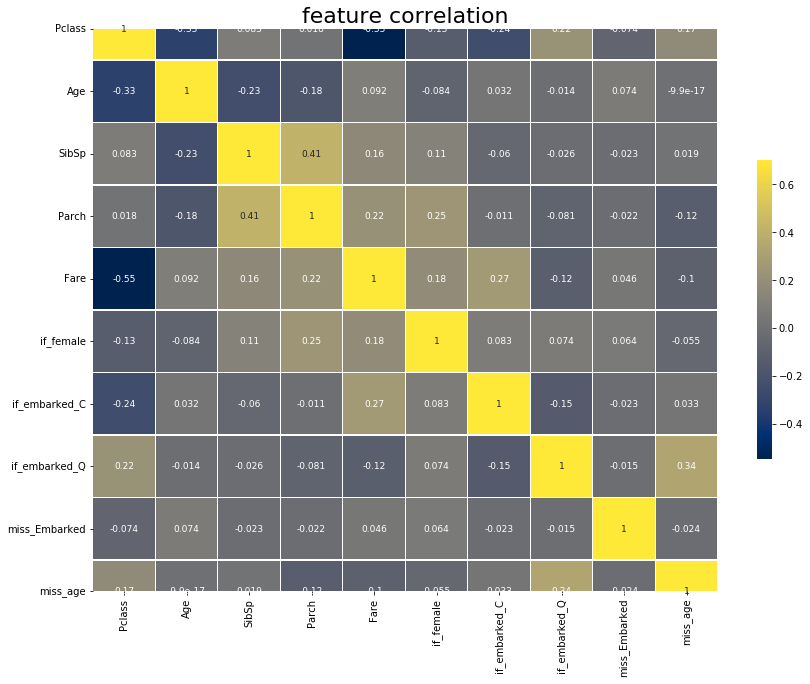

In [120]:
corr_matrix = x.corr()

corr_plot(corr_matrix, "feature correlation")

In [121]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 10) (268, 10)
Accuracy:  0.821
Precision: 0.794
Recall:    0.733
F1:        0.762


### 5. Use zero values + missing_age feature

In [21]:
df_nonmiss = df_num.copy()
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = 0

y = df_nonmiss.pop(target)
x = df_nonmiss

df_nonmiss.tail()

,Pclass,Age,SibSp,Parch,Fare,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age
886,2,27.0,0,0,13.00,0,0,0,0,0
887,1,19.0,0,0,30.00,1,0,0,0,0
888,3,0.0,1,2,23.45,1,0,0,0,1
889,1,26.0,0,0,30.00,0,1,0,0,0
890,3,32.0,0,0,7.75,0,0,1,0,0


In [28]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 10) (268, 10)
Accuracy:  0.821
Precision: 0.794
Recall:    0.733
F1:        0.762


In [29]:
lr_perm = PermutationImportance(lin_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(lr_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.4579 ± 0.1316,if_female
0.1344 ± 0.0322,Pclass
0.0444 ± 0.0206,Age
0.0131 ± 0.0186,SibSp
0.0104 ± 0.0138,if_embarked_C
0.0055 ± 0.0147,if_embarked_Q
0.0025 ± 0.0037,Fare
0.0004 ± 0.0022,miss_Embarked
0.0003 ± 0.0005,Parch
-0.0031 ± 0.0042,miss_age


### Let's investigate ROC_AUC

In [131]:
thresh_list = list(np.arange(0.0, 1.0, 0.01))
thresh_list[0:5]

[0.0, 0.01, 0.02, 0.03, 0.04]

#### More features model

In [125]:
df_nonmiss = df_num.copy()
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
age_mean = df_nonmiss.Age.mean()
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = age_mean

y = df_nonmiss.pop(target)
x = df_nonmiss

In [126]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 10) (268, 10)
Accuracy:  0.821
Precision: 0.794
Recall:    0.733
F1:        0.762


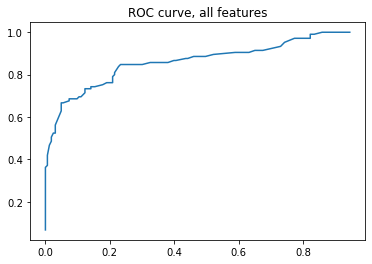

In [127]:
tpr_series = [tpr_thresh(thresh) for thresh in thresh_list]
fpr_series = [fpr_thresh(thresh) for thresh in thresh_list]

plt.plot(fpr_series, tpr_series)
plt.title('ROC curve, all features')
plt.show()

#### Simple model

In [117]:
df_nonmiss = df_num.copy()

y = df_nonmiss.pop(target)
x = df_nonmiss[['Pclass']]
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 1) (268, 1)
Accuracy:  0.687
Precision: 0.667
Recall:    0.400
F1:        0.500


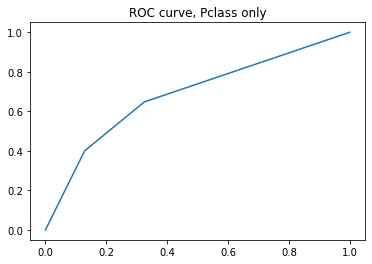

In [118]:
tpr_series_1 = [tpr_thresh(thresh) for thresh in thresh_list]
fpr_series_1 = [fpr_thresh(thresh) for thresh in thresh_list]

plt.plot(fpr_series_1, tpr_series_1)
plt.title('ROC curve, Pclass only')
plt.show()

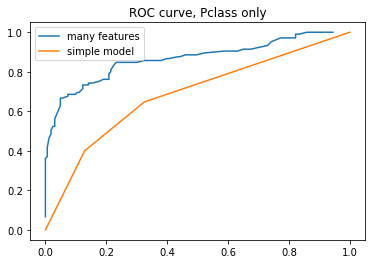

In [130]:
plt.plot(fpr_series, tpr_series, label='many features')
plt.plot(fpr_series_1, tpr_series_1, label='simple model')
plt.legend()
plt.title('ROC curve, Pclass only')
plt.show()

In [132]:
tpr_thresh(0.1), tpr_thresh(0.9)

(0.9523809523809523, 0.14285714285714285)

### How accuracy depends on threshold

In [133]:
def accuracy_thresh(thresh, y_test, y_pred_prob):
    y_pred = (y_pred_prob > thresh).astype('int')
    return accuracy_score(y_test, y_pred)

In [142]:
df_nonmiss = df_num.dropna(subset = ["Age"])

y = df_nonmiss.pop(target)
x = df_nonmiss
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
lr_perm = PermutationImportance(lin_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(lr_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5014 ± 0.1034,if_female
0.2125 ± 0.0463,Pclass
0.0660 ± 0.0634,Age
0.0222 ± 0.0128,SibSp
0.0051 ± 0.0036,if_embarked_C
0.0028 ± 0.0052,if_embarked_Q
-0.0001 ± 0.0001,Fare
-0.0013 ± 0.0077,miss_Embarked
-0.0057 ± 0.0064,Parch


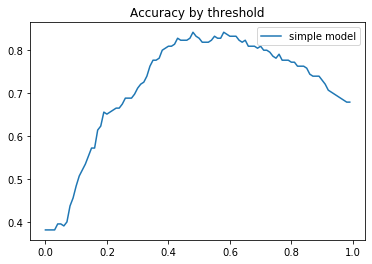

In [146]:
accuracy_series = [accuracy_thresh(thresh, y_test, y_pred_prob) for thresh in thresh_list]
plt.plot(thresh_list, accuracy_series, label='simple model')
plt.legend()
plt.title('Accuracy by threshold')
plt.show()

### HW 1: check (plot) precision_score, recall_score, f1_score for different threshold values

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


np.random.seed(42)

train = pd.read_csv('../input/train.csv')
x_train = train.drop(['id', 'species'], axis=1).values
le = LabelEncoder().fit(train['species'])
y_train = le.transform(train['species'])

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

params = {'C':[1, 10, 50, 100, 500, 1000, 2000], 'tol': [0.001, 0.0001, 0.005]}
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf = GridSearchCV(log_reg, params, scoring='log_loss', refit='True', n_jobs=1, cv=5)
clf.fit(x_train, y_train)

print("best params: " + str(clf.best_params_))
for params, mean_score, scores in clf.grid_scores_:
  print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std(), params))
  print(scores)

test = pd.read_csv('../input/test.csv')
test_ids = test.pop('id')
x_test = test.values
scaler = StandardScaler().fit(x_test)
x_test = scaler.transform(x_test)

y_test = clf.predict_proba(x_test)

submission = pd.DataFrame(y_test, index=test_ids, columns=le.classes_)
submission.to_csv('submission.csv')

ModuleNotFoundError: No module named 'sklearn.grid_search'